<a href="https://colab.research.google.com/github/TheAnders121/TestRepo/blob/main/ProjektKode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [ ]:
import os
import datetime
import time

from datetime import datetime, timedelta

#import IPython
#import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import RobustScaler
import json
import requests
import pickle

**Configurations**

In [ ]:
MAX_EPOCHS = 20

multi_val_performance = {}
multi_performance = {}

#inputTransformer = RobustScaler()
#outputTransformer = RobustScaler()

#Paths
model_path = '/content/saved_model/my_model'
plot_path = ''
historical_data = 'data.csv'
rData_path = 'data.csv'
wData_path = ''

#Model columns
direct = 'DirectSunPower kW/m²'
diffused = 'DiffuseSunPower kW/m²'
sunAltitude = 'SunAltitude °'
inputColumn = sunAltitude
outputColumn = diffused

#Model construction
steps = 24
inputColumns = 2
inputShape = [steps, inputColumns]

#Model compilation, fitting and optimization
optimizationAlgorithm = tf.keras.optimizers.Adam()
#optimizationAlgorithm = tf.keras.optimizers.SGD()
patience = 2
conf_epochs = 20

#API paths 
POST = 'somePath'
GET = 'somePath'

#Scheduler
hours = 1


**Data windowing**

**Split data**

In [ ]:
def splitData(data):
  n = len(data)
  train = data[0:int(n*0.9)] #first 90%
  test = data[int(n*0.9):] #left over 10%
  return train, test

**Create dataset**

In [ ]:
def createDatasets(input, output, timeSteps):
  inputList, outputList = [], []
  for i in range(len(input) - timeSteps):
    val = input.iloc[i: (i + timeSteps)].to_numpy()
    inputList.append(val)
    outputList.append(output.iloc[i + timeSteps])
  return np.array(inputList), np.array(outputList)

**Reshape data**

In [ ]:
def reshapeData(data, steps):
  input, output = createDatasets(data, data[outputColumn], steps)
  return [input, output]

**Transform data**

In [ ]:
def transformData(data, column):
  transformer = RobustScaler()
  transformer = transformer.fit(data[column].to_numpy())
  data.loc[:, column] = transformer.transform(data[column].to_numpy())
  return data

**Inverse transform data**

In [ ]:
def inverseTransformData(data, column=''):
  transformer = RobustScaler()
  if column == '':
    transformer = transformer.fit(data) 
  else:
    transformer = transformer.fit(data[column])
  
  inversed = transformer.inverse_transform(data)
  return inversed

**Save transformers**

In [ ]:
def save_transformers(inputTransformer, outputTransformer):   
  #Save transformers
  with open('input_transformer', 'wb') as data:
    pickle.dump(inputTransformer, data)
    
  with open('output_transformer', 'wb') as data:
    pickle.dump(outputTransformer, data)  
  print(f'Transformers have been saved succesfully')  

**Load transformers**

In [ ]:
def load_transformers():
  with open('input_transformer', 'rb') as data:
    inputTransformer = pickle.load(data)
 

  with open('output_transformer', 'rb') as data:
    #Load
    outputTransformer = pickle.load(data)

  return inputTransformer, outputTransformer        

**To json string**

In [ ]:
def toJson(string):
  return json.dumps(string)

**Convert Json string**

In [ ]:
def toNormal(string):
  return json.loads(string)

**Write predictions to file**

In [ ]:
def writePredictions(string):
  # Append-adds at last
  file1 = open(wData_path, "w")  #write mode (overwrite previous predictions)
  file1.write(string)
  file1.close()

**Upload predictions**

In [ ]:
def uploadPredictions(): 
  api_url = POST
  todo = {"userId": 1, "title": "Buy milk", "completed": False} #this should actually be a file with new predictions
  response = requests.post(api_url, json=todo)
  return response.status_code

**Build model**

In [ ]:
def buildModel():
  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128, 
        input_shape=inputShape
      )
    )
  )
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=1))
  return model

**Compile**

In [ ]:
def compile(model, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=optimizationAlgorithm,
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
  return model

**Fit model**

In [ ]:
def fit(model, input, output):
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
  history = model.fit(
    input, output,
    epochs=conf_epochs,
    batch_size=32,
    callbacks=[callback],
    validation_split=0.1,
    shuffle=False
  )
  return history

**Save weights**

**Load weights**

**Save model**

In [ ]:
#model - model that is to be saved (needs to be a tf.keras.model object)
#path - under which path the model will be saved (and can be accessed)
def save_model(model, path):
  model.save(path)

**Load model**

In [ ]:
#path - under which path the model will be accessible
def load_model(path):
  new_model = tf.keras.models.load_model(path)

  return new_model

**Load data**

In [ ]:
#path - path to where the data is to be loaded from 
def load_data(path):
  dt = pd.read_csv(path, sep=";",thousands='.', decimal=',') #read csv file with ';' as seperator and ',' as decimal marker (will be converted to '.')
  return dt

**Process data**

In [ ]:
#data - data that is to be processed in order for the model to read it
def process_data(data):
  # Convert to radians.
  data[sunAltitude] = data[sunAltitude]*np.pi / 180
  #data[[diffused, sunAltitude]].copy() #return only two relevant columns
  #return data[[sunAltitude]].copy() #return only relevant column
  return data

**Predict**

In [ ]:
#data - 48 datapoints for the model to predict the next 24 datapoints
def make_prediction(model, data, plot):
  if plot == False:
    prediction = model.predict(data)
    return prediction
  #Code to return plot 


**Send prediction**

**Main function**

In [ ]:
'''
print("Hello from main")

model = load_model(model_path)

##In loop

if not model:
  model = load_model(model_path)
  if not model:
    print('Model could not be loaded')
    print('Constructing model... This could take some time')
    #Construct model method
    if not model:
      print('Model could be not constructed')
      #Break loop

data = load_data(rData_path)
#Isolate needed columns

data = process_data(data)
#shift data
data = reshapeData(data, steps)

inputTransformer = RobustScaler() #These need to be grabbed from a file from training session
outputTransformer = RobustScaler()

tData = transformData(data) #Also pass transformer objects

predictions = make_prediction(model, data, False)

jsonString = toJson(inverseTransformData(predictions)) #should also pass transformer object

#Upload predictions, this would probably just be through a print method
print(jsonString)


while True:
  #Do work
  data = process_data(load_data(rData_path))
  data = reshapeData(data, steps)
  tData = transformData(data)
  model = load_model(model_path)
  predictions = make_prediction(model, data, False)
  jsonString = toJson(inverseTransformData(predictions))
  code = uploadPredictions()
  #check status code 

  
  time.sleep(3600 * hours)  # do work every x amount of hours
'''

'''

TypeError: ignored

**Unzip file**

In [ ]:
#!unzip /content/LSTM_Model.zip

**Load test data**

In [ ]:
dt = pd.read_csv('data.csv', sep=";",thousands='.', decimal=',') #read csv file with ';' as seperator and ',' as decimal marker (will be converted to '.')

dt['SunAltitude °'] = dt['SunAltitude °']*np.pi / 180 #Get radians

diffuseSunData = dt[['DiffuseSunPower kW/m²','SunAltitude °']].copy()

n = len(diffuseSunData)
train_diffuseSunData = diffuseSunData[0:int(n*0.7)] #first 70%
val_diffuseSunData = diffuseSunData[int(n*0.7):int(n*0.9)] #following 20%
test_diffuseSunData = diffuseSunData[int(n*0.9):] #left over 10%

**Normalize data** 

In [ ]:
train_mean = diffuseSunData.mean()
train_var = diffuseSunData.var()

train_diffuseSunData = (train_diffuseSunData - train_mean) / train_var
val_diffuseSunData = (val_diffuseSunData - train_mean) / train_var
test_diffuseSunData = (test_diffuseSunData - train_mean) / train_var

**Denormalize**

In [ ]:
def denormalize(data):
  min_d = np.min(data)
  max_d = np.max(data)
  return (data - min_d) / (max_d - min_d)

**Model construction 3 input**

0       2020-10-04 12:00:00
1       2020-10-04 13:00:00
2       2020-10-04 14:00:00
3       2020-10-04 15:00:00
4       2020-10-04 16:00:00
                ...        
15248   2022-07-01 20:00:00
15249   2022-07-01 21:00:00
15250   2022-07-01 22:00:00
15251   2022-07-01 23:00:00
15252   2022-07-02 00:00:00
Name: DATE, Length: 15253, dtype: datetime64[ns]
0        04-10-2020 12:00:00
1        04-10-2020 13:00:00
2        04-10-2020 14:00:00
3        04-10-2020 15:00:00
4        04-10-2020 16:00:00
                ...         
15248    01-07-2022 20:00:00
15249    01-07-2022 21:00:00
15250    01-07-2022 22:00:00
15251    01-07-2022 23:00:00
15252    02-07-2022 00:00:00
Name: DATE, Length: 15253, dtype: object
0        1.601813e+09
1        1.601816e+09
2        1.601820e+09
3        1.601824e+09
4        1.601827e+09
             ...     
15248    1.656706e+09
15249    1.656709e+09
15250    1.656713e+09
15251    1.656716e+09
15252    1.656720e+09
Name: Seconds, Length: 15253, dtype: floa

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Dataset shape set to: ((13682, 24, 4), (13682,))
Set model input shape to: (13682, 24)
Input data: [[[ 1.83237084e+00  5.84821853e-13 -7.07106781e-01  2.00000000e+00]
  [ 1.82737631e+00 -1.83012702e-01 -6.83012702e-01  2.50000000e+00]
  [ 1.66942407e+00 -3.53553391e-01 -6.12372436e-01  2.33333333e+00]
  ...
  [ 9.93288591e-01  5.00000000e-01 -5.00000000e-01  1.00000000e+00]
  [ 1.37974091e+00  3.53553391e-01 -6.12372436e-01  1.66666667e+00]
  [ 1.66130794e+00  1.83012702e-01 -6.83012702e-01  1.83333333e+00]]

 [[ 1.82737631e+00 -1.83012702e-01 -6.83012702e-01  2.50000000e+00]
  [ 1.66942407e+00 -3.53553391e-01 -6.12372436e-01  2.33333333e+00]
  [ 1.37786796e+00 -5.00000000e-01 -5.00000000e-01  2.00000000e+00]
  ...
  [ 1.37974091e+00  3.53553391e-01 -6.12372436e-01  1.66666667e+00]
  [ 1.66130794e+00  1.83012702e-01 -6.83012702e-01  1.83333333e+00]
  [ 1.80864679e+00  7.83505398e-12 -7.07106781e-01  1.83333333e+00]]

 [[ 1.66942407e+00 -3.53553391e-01 -6.12372436e-01  2.33333333e+00]
 

RobustScaler()
RobustScaler()
Transformers have been saved succesfully


ValueError: ignored

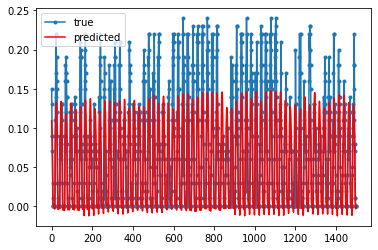

In [ ]:
  #Load data
data = load_data(historical_data)


#PRETTIFY#
  #Get date to cos sine values
dateColumn = pd.to_datetime(data['DATE'], format='%d-%m-%Y %H:%M:%S')  # convert the index to datetime
print(dateColumn)
print(data['DATE'])

data['Seconds'] = dateColumn.map(pd.Timestamp.timestamp)  # convert the index to seconds
print(data['Seconds'])


day = 60*60*24  # get the number of seconds in a day
data['Day sin']  = np.sin(data['Seconds'] * (2 * np.pi / day))  # add the sin of the seconds
data['Day cos']  = np.cos(data['Seconds'] * (2 * np.pi / day))  # add the cos of the seconds

print(data['Day sin'])
print(data['Day cos'])

#data = data.drop('Seconds', axis=1) # remove the seconds column
#data = data.drop("Time", axis=1)  # remove the time column
#PRETTIFY#

  #Isolate data
data = data[[inputColumn, 'Day sin', 'Day cos', outputColumn]].copy()

  #Process data columns
data = process_data(data)
#testData = data.tail(48)

  #Shift data
shiftDays = 1 
shiftSteps = shiftDays * 24

shiftedData = data[outputColumn].shift(-shiftSteps)

#shiftedData = data
#shiftedData[outputColumn] = shiftedData[outputColumn].shift(-shiftSteps)

  #Verify shifted data
print(data[outputColumn].head(shiftSteps + 5))
print(shiftedData.head(5))
print(shiftedData.tail()) #this should be NaN, since the data has been shifted backwards (down)

  #Set shifted data as new output column
data[outputColumn] = shiftedData

  #Delete empty rows in tail
data.drop(data.tail(shiftSteps).index,inplace=True)
print(f'Verify empty tail is removed: {data.tail(shiftDays)}')


  #Split data
train, test = splitData(data)
print(f'Split shifted data: {splitData(data)}')
#print(f'Split shifted data: {splitData(shiftedData)}')


  #Transform data
#train = transformData(data[0], [inputColumn, outputColumn])
#test = transformData(data[1], [inputColumn, outputColumn])

inputTransformer = RobustScaler()
outputTransformer = RobustScaler()

inputTransformer = inputTransformer.fit(train[[inputColumn,'Day sin', 'Day cos']].to_numpy())
outputTransformer = outputTransformer.fit(train[[outputColumn]]) #No need to transform into numpy

train.loc[:, [inputColumn,'Day sin', 'Day cos']] = inputTransformer.transform(train[[inputColumn,'Day sin', 'Day cos']].to_numpy())
train[outputColumn] = outputTransformer.transform(train[[outputColumn]])

test.loc[:,  [inputColumn,'Day sin', 'Day cos']] = inputTransformer.transform(test[[inputColumn, 'Day sin', 'Day cos']].to_numpy())
test[outputColumn] = outputTransformer.transform(test[[outputColumn]])

print(f'Transformed test data: {train}')
#print(train[[inputColumn, 'Day sin', 'Day cos']])

  #Create dataset
#input, output = createDatasets(train[inputColumn], train[outputColumn], steps)
input, output = createDatasets(train[[inputColumn, 'Day sin', 'Day cos']], train[outputColumn], steps)

print(f'Dataset shape set to: {input.shape, output.shape}')
print(f'Set model input shape to: {input.shape[0], input.shape[1]}')
print(f'Input data: {input}')
print(f'Output data: {output}')

model = keras.Sequential()

model.add(keras.layers.GRU(units=128,
             # return_sequences=True,
              input_shape=(24, 3))
        )
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

  #Compile model
model = compile(model)
#model.compile(loss='mean_squared_error', optimizer='adam')

  #Fit model
history = fit(model, input, output)

  #Create test dataset
#testInput, testOutput = createDatasets(test, test[outputColumn], steps)
testInput, testOutput = createDatasets(test[[inputColumn, 'Day sin', 'Day cos']], test[outputColumn], steps)

print(f'Test data shape: {testInput.shape}')
print(f'Input: {testInput}')

  #Make prediction
prediction = make_prediction(model, testInput, False)
print(f'Predictions: {prediction}')
print(f'Expected output: {testOutput}')

  #Inverse transform data
predictionInverse = outputTransformer.inverse_transform(prediction)
outputTestInv = outputTransformer.inverse_transform(testOutput.reshape(-1, 1))
print(f'Inverse transformed predictions: {predictionInverse[20:40]}')
print(f'Inverse transformed predictions expected output: {outputTestInv[20:40]}')

print(f'Predict vs actual: { np.max(prediction), np.max(testOutput)}')
print(f'Predict vs actual: { np.min(prediction), np.min(testOutput)}')


#print(f'Prediction output shape: {inverseTransformData(prediction).shape}')
#print(f'Prediction values: {inverseTransformData(prediction)}')

#print(f'Real values: {data[1].head(20)}')
#print(f'Real values: {inverseTransformData(np.reshape(testOutput,(-1,1)))}')
#look = inverseTransformData(np.reshape(testOutput,(-1,1)))
#print(look[-20:, :])
#print(f'Shapes {testOutput.shape, look.shape}')

  #Plot predictions vs test data
#plt.plot(prediction.flatten(), marker='.', label='true')
#plt.plot(testOutput.flatten(), 'r', label='predicted')
#plt.legend()


  #Plot predictions vs test data
plt.plot(outputTestInv.flatten(), marker='.', label='true')
plt.plot(predictionInverse.flatten(), 'r', label='predicted')
plt.legend()

  #Inspect 
#print(predictionInverse[0:23])
#print(outputTestInv[0:23])

#testData.loc[:, inputColumn] = inputTransformer.transform(testData[[inputColumn]].to_numpy())
#testData[outputColumn] = outputTransformer.transform(testData[[outputColumn]])

#testInput, testOutput = createDatasets(testData, testData[outputColumn], steps)

#testPred = make_prediction(model, testInput[0:23], False)
#print(testInput)
#print(testPred)
#print(testOutput)

  #Save model
save_model(model, model_path)


#MAYBE
  #Save transformers
with open('input_transformer', 'wb') as config_dictionary_file:
    pickle.dump(inputTransformer, config_dictionary_file)
  
with open('output_transformer', 'wb') as config_dictionary_file:
    pickle.dump(outputTransformer, config_dictionary_file)

  #Load transformer
# Step 2
with open('input_transformer', 'rb') as config_dictionary_file:
 
    # Step 3
    config_dictionary = pickle.load(config_dictionary_file)
 
    # After config_dictionary is read from file
    print(config_dictionary)

with open('output_transformer', 'rb') as config_dictionary_file:
 
    # Step 3
    config_dictionary2 = pickle.load(config_dictionary_file)
 
    # After config_dictionary is read from file
    print(config_dictionary2)

save_transformers(inputTransformer, outputTransformer)
t1, t2 = load_transformers()

arr = [[1, 2, 3],[5, 6, 7]]

arr2 = t1.transform(arr)
print(arr)
print(arr2)

arr3 = t2.inverse_transform(arr2)
print(arr2)
print(arr3)
print(outputTransformer.inverse_transform(arr2))

Tarr = [[1, 2, 3],[5, 6, 7]]

Tarr2 = inputTransformer.transform(Tarr)
print(Tarr2)
print(outputTransformer.inverse_transform(Tarr2))
#MAYBE

  #Load model
#model2 = load_model(model_path)

#model2.summary()


**GRU 4 inputs**

In [ ]:
  #Load data
data = load_data(historical_data)


#PRETTIFY#
  #Get date to cos sine values
dateColumn = pd.to_datetime(data['DATE'], format='%d-%m-%Y %H:%M:%S')  # convert the index to datetime
print(dateColumn)
print(data['DATE'])

data['Seconds'] = dateColumn.map(pd.Timestamp.timestamp)  # convert the index to seconds
print(data['Seconds'])


day = 60*60*24  # get the number of seconds in a day
data['Day sin']  = np.sin(data['Seconds'] * (2 * np.pi / day))  # add the sin of the seconds
data['Day cos']  = np.cos(data['Seconds'] * (2 * np.pi / day))  # add the cos of the seconds

print(data['Day sin'])
print(data['Day cos'])

#data = data.drop('Seconds', axis=1) # remove the seconds column
#data = data.drop("Time", axis=1)  # remove the time column
#PRETTIFY#

  #Isolate data
data = data[[inputColumn, 'Day sin', 'Day cos', outputColumn]].copy()

  #Process data columns
data = process_data(data)
#testData = data.tail(48)

  #Shift data
shiftDays = 1 
shiftSteps = shiftDays * 24

shiftedData = data[outputColumn].shift(-shiftSteps)

#shiftedData = data
#shiftedData[outputColumn] = shiftedData[outputColumn].shift(-shiftSteps)

  #Verify shifted data
print(data[outputColumn].head(shiftSteps + 5))
print(shiftedData.head(5))
print(shiftedData.tail()) #this should be NaN, since the data has been shifted backwards (down)

  #Set shifted data as new output column
#data[outputColumn] = shiftedData
data['Shifted'] = shiftedData

  #Delete empty rows in tail
data.drop(data.tail(shiftSteps).index,inplace=True)
print(f'Verify empty tail is removed: {data.tail(shiftDays)}')


  #Split data
train, test = splitData(data)
print(f'Split shifted data: {splitData(data)}')
#print(f'Split shifted data: {splitData(shiftedData)}')


  #Transform data
#train = transformData(data[0], [inputColumn, outputColumn])
#test = transformData(data[1], [inputColumn, outputColumn])

inputTransformer = RobustScaler()
outputTransformer = RobustScaler()

inputTransformer = inputTransformer.fit(train[[inputColumn,'Day sin', 'Day cos', outputColumn]].to_numpy())
outputTransformer = outputTransformer.fit(train[['Shifted']]) #No need to transform into numpy

train.loc[:, [inputColumn,'Day sin', 'Day cos', outputColumn]] = inputTransformer.transform(train[[inputColumn,'Day sin', 'Day cos', outputColumn]].to_numpy())
train['Shifted'] = outputTransformer.transform(train[['Shifted']])

test.loc[:,  [inputColumn,'Day sin', 'Day cos', outputColumn]] = inputTransformer.transform(test[[inputColumn, 'Day sin', 'Day cos', outputColumn]].to_numpy())
test['Shifted'] = outputTransformer.transform(test[['Shifted']])

print(f'Transformed test data: {train}')
#print(train[[inputColumn, 'Day sin', 'Day cos']])

  #Create dataset
#input, output = createDatasets(train[inputColumn], train[outputColumn], steps)
input, output = createDatasets(train[[inputColumn, 'Day sin', 'Day cos', outputColumn]], train['Shifted'], steps)

print(f'Dataset shape set to: {input.shape, output.shape}')
print(f'Set model input shape to: {input.shape[0], input.shape[1]}')
print(f'Input data: {input}')
print(f'Output data: {output}')

model = keras.Sequential()

model.add(keras.layers.GRU(units=128,
             # return_sequences=True,
              input_shape=(24, 4))
        )
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

  #Compile model
model = compile(model)
#model.compile(loss='mean_squared_error', optimizer='adam')

  #Fit model
history = fit(model, input, output)

  #Create test dataset
#testInput, testOutput = createDatasets(test, test[outputColumn], steps)
testInput, testOutput = createDatasets(test[[inputColumn, 'Day sin', 'Day cos', outputColumn]], test['Shifted'], steps)

print(f'Test data shape: {testInput.shape}')
print(f'Input: {testInput}')

  #Make prediction
prediction = make_prediction(model, testInput, False)
print(f'Predictions: {prediction}')
print(f'Expected output: {testOutput}')

  #Inverse transform data
predictionInverse = outputTransformer.inverse_transform(prediction)
outputTestInv = outputTransformer.inverse_transform(testOutput.reshape(-1, 1))
print(f'Inverse transformed predictions: {predictionInverse[20:40]}')
print(f'Inverse transformed predictions expected output: {outputTestInv[20:40]}')

print(f'Predict vs actual: { np.max(prediction), np.max(testOutput)}')
print(f'Predict vs actual: { np.min(prediction), np.min(testOutput)}')


#print(f'Prediction output shape: {inverseTransformData(prediction).shape}')
#print(f'Prediction values: {inverseTransformData(prediction)}')

#print(f'Real values: {data[1].head(20)}')
#print(f'Real values: {inverseTransformData(np.reshape(testOutput,(-1,1)))}')
#look = inverseTransformData(np.reshape(testOutput,(-1,1)))
#print(look[-20:, :])
#print(f'Shapes {testOutput.shape, look.shape}')

  #Plot predictions vs test data
#plt.plot(prediction.flatten(), marker='.', label='true')
#plt.plot(testOutput.flatten(), 'r', label='predicted')
#plt.legend()


  #Plot predictions vs test data
plt.plot(outputTestInv.flatten(), marker='.', label='true')
plt.plot(predictionInverse.flatten(), 'r', label='predicted')
plt.legend()

  #Inspect 
#print(predictionInverse[0:23])
#print(outputTestInv[0:23])

#testData.loc[:, inputColumn] = inputTransformer.transform(testData[[inputColumn]].to_numpy())
#testData[outputColumn] = outputTransformer.transform(testData[[outputColumn]])

#testInput, testOutput = createDatasets(testData, testData[outputColumn], steps)

#testPred = make_prediction(model, testInput[0:23], False)
#print(testInput)
#print(testPred)
#print(testOutput)

  #Save model
save_model(model, model_path)


#MAYBE
  #Save transformers
with open('input_transformer', 'wb') as config_dictionary_file:
    pickle.dump(inputTransformer, config_dictionary_file)
  
with open('output_transformer', 'wb') as config_dictionary_file:
    pickle.dump(outputTransformer, config_dictionary_file)

  #Load transformer
# Step 2
with open('input_transformer', 'rb') as config_dictionary_file:
 
    # Step 3
    config_dictionary = pickle.load(config_dictionary_file)
 
    # After config_dictionary is read from file
    print(config_dictionary)

with open('output_transformer', 'rb') as config_dictionary_file:
 
    # Step 3
    config_dictionary2 = pickle.load(config_dictionary_file)
 
    # After config_dictionary is read from file
    print(config_dictionary2)

save_transformers(inputTransformer, outputTransformer)
t1, t2 = load_transformers()

arr = [[1, 2, 3],[5, 6, 7]]

arr2 = t1.transform(arr)
print(arr)
print(arr2)

arr3 = t2.inverse_transform(arr2)
print(arr2)
print(arr3)
print(outputTransformer.inverse_transform(arr2))

Tarr = [[1, 2, 3],[5, 6, 7]]

Tarr2 = inputTransformer.transform(Tarr)
print(Tarr2)
print(outputTransformer.inverse_transform(Tarr2))
#MAYBE

  #Load model
#model2 = load_model(model_path)

#model2.summary()


**Method to test models**

In [ ]:
def model_test(model):
    #Load data
    data = load_data(historical_data)

      #Isolate data
    data = data[[inputColumn, outputColumn]].copy()

      #Process data columns
    data = process_data(data)
    testData = data.tail(48)

      #Shift data
    shiftDays = 1 
    shiftSteps = shiftDays * 24

    shiftedData = data[outputColumn].shift(-shiftSteps)

    #shiftedData = data
    #shiftedData[outputColumn] = shiftedData[outputColumn].shift(-shiftSteps)

      #Verify shifted data
    print(data[outputColumn].head(shiftSteps + 5))
    print(shiftedData.head(5))
    print(shiftedData.tail()) #this should be NaN, since the data has been shifted backwards (down)

      #Set shifted data as new output column
    data[outputColumn] = shiftedData

      #Delete empty rows in tail
    data.drop(data.tail(shiftSteps).index,inplace=True)
    print(f'Verify empty tail is removed: {data.tail(shiftDays)}')


      #Split data
    train, test = splitData(data)
    print(f'Split shifted data: {splitData(data)}')
    #print(f'Split shifted data: {splitData(shiftedData)}')


      #Transform data
    #train = transformData(data[0], [inputColumn, outputColumn])
    #test = transformData(data[1], [inputColumn, outputColumn])

    inputTransformer = RobustScaler()
    outputTransformer = RobustScaler()

    inputTransformer = inputTransformer.fit(train[[inputColumn]].to_numpy())
    outputTransformer = outputTransformer.fit(train[[outputColumn]]) #No need to transform into numpy

    train.loc[:, inputColumn] = inputTransformer.transform(train[[inputColumn]].to_numpy())
    train[outputColumn] = outputTransformer.transform(train[[outputColumn]])

    test.loc[:, inputColumn] = inputTransformer.transform(test[[inputColumn]].to_numpy())
    test[outputColumn] = outputTransformer.transform(test[[outputColumn]])

    print(f'Test data: {train}')


      #Create dataset
    #input, output = createDatasets(train[inputColumn], train[outputColumn], steps)
    input, output = createDatasets(train, train[outputColumn], steps)

    print(f'Dataset shape set to: {input.shape, output.shape}')
    print(f'Set model input shape to: {input.shape[0], input.shape[1]}')
    print(f'Input data: {input}')
    print(f'Output data: {output}')

      #Build model
    #model = keras.Sequential()
    #model.add(
   #   keras.layers.Bidirectional(
   #     keras.layers.LSTM(
   #       units=128, 
   #       input_shape=(input.shape[1], input.shape[2])
          #input_shape=(input.shape[0], input.shape[1])
   #     )
   #   )
  #  )
  #  model.add(keras.layers.Dropout(rate=0.2))
  #  model.add(keras.layers.Dense(units=1))

      #Compile model
    model = compile(model)
    #model.compile(loss='mean_squared_error', optimizer='adam')

      #Fit model
    history = fit(model, input, output)

      #Create test dataset
    testInput, testOutput = createDatasets(test, test[outputColumn], steps)
    print(f'Test data shape: {testInput.shape}')
    print(f'Input: {testInput}')

      #Evaluate model 
    print("EVALUATION START")  
    scores = model.evaluate(testInput, testOutput, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1])) 
   
    cvscores = []
    cvscores.append(scores[1])
 
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    print("EVALUATION END")  

      #Make prediction
    prediction = make_prediction(model, testInput, False)
    print(f'Predictions: {prediction}')

      #Inverse transform data
    predictionInverse = outputTransformer.inverse_transform(prediction)
    outputTestInv = outputTransformer.inverse_transform(testOutput.reshape(-1, 1))

    #print(f'Prediction output shape: {inverseTransformData(prediction).shape}')
    #print(f'Prediction values: {inverseTransformData(prediction)}')

    #print(f'Real values: {data[1].head(20)}')
    #print(f'Real values: {inverseTransformData(np.reshape(testOutput,(-1,1)))}')
    #look = inverseTransformData(np.reshape(testOutput,(-1,1)))
    #print(look[-20:, :])
    #print(f'Shapes {testOutput.shape, look.shape}')


      #Plot predictions vs test data
    plt.plot(outputTestInv.flatten(), marker='.', label='true')
    plt.plot(predictionInverse.flatten(), 'r', label='predicted')
    plt.legend()

      #Inspect 
    print(predictionInverse[0:23])
    print(outputTestInv[23:47])

    print(make_prediction(model, testData[0:23], False))
    print(testData)
    return history

**Model tester**

In [ ]:
GRU2 = keras.Sequential()

GRU2.add(keras.layers.GRU(units=128,
             # return_sequences=True,
              input_shape=(24, 2))
        )
GRU2.add(keras.layers.Dropout(rate=0.2))
GRU2.add(keras.layers.Dense(units=1))


perf_history['GRU2'] = model_test(GRU2)